### Exercice 1.1  - Computational Geomechanics 2024-2025

The goal of this exercise is to understand the so-called "projection" procedure which consist in obtaining/projecting the flux at the nodes
from the knowledge of the solution at the nodes. We assume Darcy's law : $q_i = - k h_{,i}$

On the unit square, let's assume that the head h has the following form : $h(x,y) = \sin(\pi x) \sinh(\pi y) / \sinh(\pi)$, which is actually a solution of the Laplacian.

### External libraries

We will use `python` and it's many computing libraries to do finite element computations. Here are some of the libraries we will use:

- `numpy` stands for *numerical python* and is the main library used, along with `scipy`, for scientific computing. You can access the documentation [here](https://numpy.org/doc/stable/).
- `matplotlib` is a library used for plotting purposes. The documentation is accessible [here](https://matplotlib.org/stable/index.html).
- `pygmsh` is a python wrapper for the mesh generator `gmsh`. We will generate meshes with this library and manipulate it's output with our own code. You can access `pygmsh` documentation at the following [link](https://pygmsh.readthedocs.io/en/latest/index.html).

In [1]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt
import pygmsh

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../../src')

from MesherWrapper import Mesh
import MatrixAssembly
import PoroElasticProperties as prop

### 1. Mesh generation

Here we will create a unit square mesh which is a GMSH object and later parse it with our own parser contained in the class Mesh (`Mesh.py`).
Please see how you can build other shapes with GMSH in its [manual](https://pygmsh.readthedocs.io/en/latest/index.html).

(<Figure size 640x480 with 1 Axes>, <Axes: >)

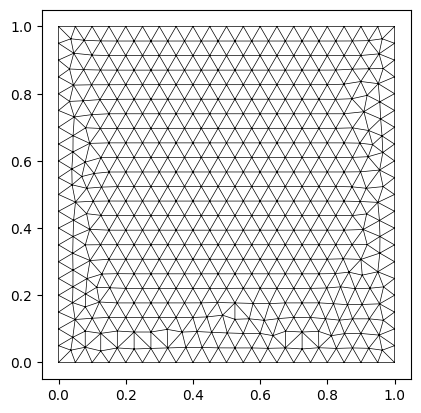

In [2]:
# You can easily build a rectangle with the following code:
with pygmsh.geo.Geometry() as geom:
    rec = geom.add_rectangle(0, 1, 0, 1, 0, mesh_size=0.05)
    out = geom.generate_mesh()

# We use the object generated by pygmsh (a meshio object)
mesh = Mesh(out)
# let's plot the mesh by using the function Mesh::plot(args) of our class Mesh.
mesh.plot()

In [3]:
connectivity = out.cells_dict['triangle']
print(connectivity)
np.unique(connectivity)
used_nodes = np.zeros(len(out.points), dtype=bool)
used_nodes[np.unique(connectivity)] = True
nodes = out.points[used_nodes, :2]
index_map = np.zeros(len(out.points), dtype=int)
index_map[used_nodes] = np.arange(len(nodes))
new_connectivity = index_map[connectivity]
print(new_connectivity)

[[460 390 492]
 [385  87 473]
 [343 238 437]
 ...
 [332 476 510]
 [305 485 511]
 [315 491 512]]
[[460 390 492]
 [385  87 473]
 [343 238 437]
 ...
 [332 476 510]
 [305 485 511]
 [315 491 512]]


The ``Mesh`` object has built-in functions and class member. 
1. ``mesh.nodes`` contains the nodes' coordinates and has the shape ``(number_of_nodes, spatial_dimension)``;
2. ``mesh.connecitivity`` contains nodes composing each element and it is of shape ``(number_of_elements, number_of_nodes_per_element)``;
3. ``mesh.number_nodes`` contains the total number of nodes;
4. ``mesh.number_els`` is the total number of elements in the mesh.

In the following, please output how many nodes and element the mesh has and also the coordinate of the 1st node and the connectivity of the 1st element.

In [3]:
print(f'The total number of nodes is {mesh.number_nodes}')
# complete the missing part of the task below
print(f'The total number of elements is {mesh.number_els}')
print(f'The coordinates of the first node are {mesh.nodes[0]}')
print(f'The connectivity of the first element is {mesh.connectivity[0]}')

The total number of nodes is 513
The total number of elements is 944
The coordinates of the first node are [0. 0.]
The connectivity of the first element is [460 390 492]


### 2. Laplacian problem

The problem given says that the analytical solution of a Laplacian problem is 
 
$h(x, y) = \sin(\pi x) \sinh(\pi y)/\sinh(\pi)$,

and the fluxes $q_x$ and $q_y$ being

$q_x (x, y) = \frac{-\pi \cos(\pi x) \sinh(\pi y)}{\sinh(\pi)}$,

$q_y (x, y) = \frac{-\pi \sin(\pi x) \cosh(\pi y)}{\sinh(\pi)}$

Let us visualize this solution using ``Mesh::plot`` function. Familiarize yourself with this function - it will be used extensively later.

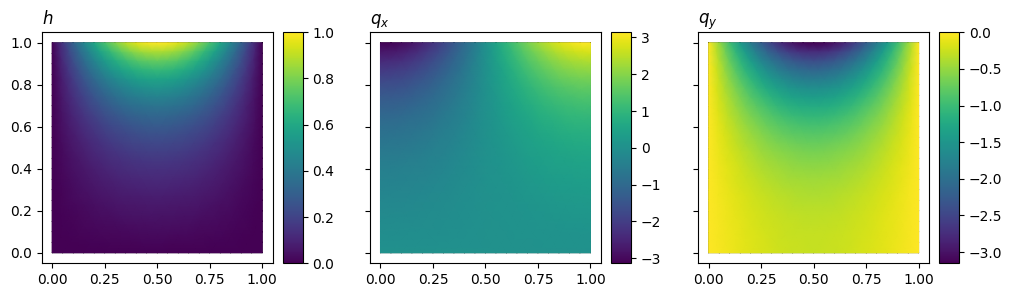

In [4]:
x, y = mesh.nodes[:, 0], mesh.nodes[:, 1]

h = np.sin(np.pi * x) * np.sinh(np.pi * y)/np.sinh(np.pi)

q_x_true = - np.pi * np.cos(np.pi * x) * np.sinh(np.pi * y)/np.sinh(np.pi)
q_y_true = - np.pi * np.sin(np.pi * x) * np.cosh(np.pi * y)/np.sinh(np.pi)

fig, axs = plt.subplots(1, 3, sharey='all', figsize=(12, 3))
mesh.plot(h, ax=axs[0])
mesh.plot(q_x_true, ax=axs[1])
mesh.plot(q_y_true, ax=axs[2])

axs[0].set_title('$h$', loc='left')
axs[1].set_title('$q_x$', loc='left')
axs[2].set_title('$q_y$', loc='left')

for ax in axs:
    ax.set_aspect(1)

### 3. Projection of the flux to the nodes

We want to compute the fluxes only from the given solution of water heads $h$. As gradients of heads are computed at the integration points, the fluxes are also defined there. This makes plotting task complicated, as fluxes become discontinuous at the elemental boundaries. In order to improve that, we want to have fluxes defined at the nodes, which would make flux field continuous and easily plottable. Defining fluxes at the nodes requires projection operation. We will use a `project_flux` function that computes the fluxes at the integration points and then projects them at the nodes.

To make the following cell work, you have to complete the code of the function MatrixAssembly::project(args) in Assembly.py

In [5]:
q_x_num, q_y_num = MatrixAssembly.project_flux(mesh, 1, h)

### 4. Error estimates

In the following cell we will compute the node-wise absolute error for $q_x$ and $q_y$ and plot them in two different figures

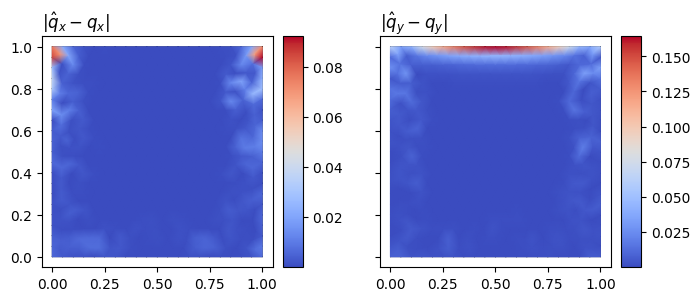

In [6]:
# complete the code below
abs_q_x = np.abs(q_x_num - q_x_true)
abs_q_y = np.abs(q_y_num - q_y_true)


fig, axs = plt.subplots(1, 2, sharey='all', figsize=(8, 3))
# complete the code below
mesh.plot(abs_q_x, ax=axs[0], cmap='coolwarm')
mesh.plot(abs_q_y, ax=axs[1], cmap='coolwarm')


axs[0].set_title('$|\hat{q}_x - q_x|$ ', loc='left')
axs[1].set_title('$|\hat{q}_y -q_y|$', loc='left')

for ax in axs:
    ax.set_aspect(1)

### Visualisation of the analytical solution, numerical approximation and the absolute error

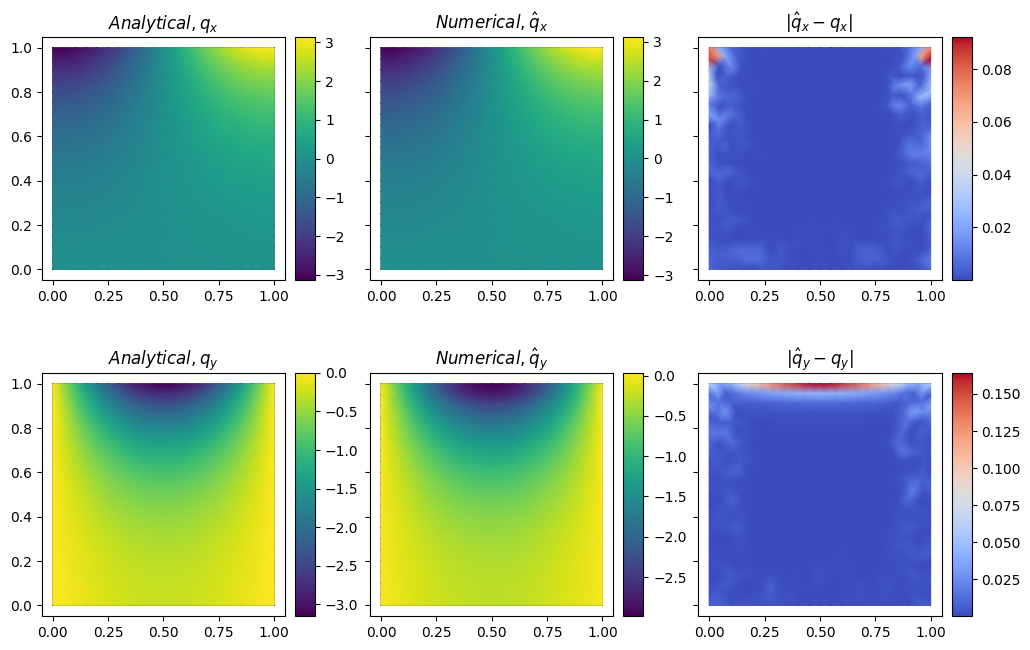

In [18]:
fig, axs = plt.subplots(2, 3, sharey='all', figsize=(12, 8))
# complete the code below
mesh.plot(q_x_true, ax=axs[0, 0])
mesh.plot(q_x_num, ax=axs[0, 1])
mesh.plot(abs_q_x, ax=axs[0,2], cmap='coolwarm')
mesh.plot(q_y_true, ax=axs[1, 0])
mesh.plot(q_y_num, ax=axs[1, 1])
mesh.plot(abs_q_y, ax=axs[1,2], cmap='coolwarm')

axs[0,0].set_title('$Analytical, q_x$', loc='center')
axs[1,0].set_title('$Analytical, q_y$', loc='center')
axs[0,1].set_title('$Numerical, \hat{q}_x$', loc='center')
axs[1,1].set_title('$Numerical, \hat{q}_y$', loc='center')
axs[1,0].set_title('$Analytical, q_y$', loc='center')
axs[0,2].set_title('$|\hat{q}_x - q_x|$ ', loc='center')
axs[1,2].set_title('$|\hat{q}_y -q_y|$', loc='center')


# Set aspect ratio to be equal for all subplots
for ax in axs.flat:
    ax.set_aspect('equal')
    



Here, we will compute the relative error (rel_error = absolute error / abs(exact solution)) and plot it. As exact solution equals to zero at some nodes, we will replace the relative error at these positions by the absolute values (rel error = abs error where abs(q_true) < 1.e-8).

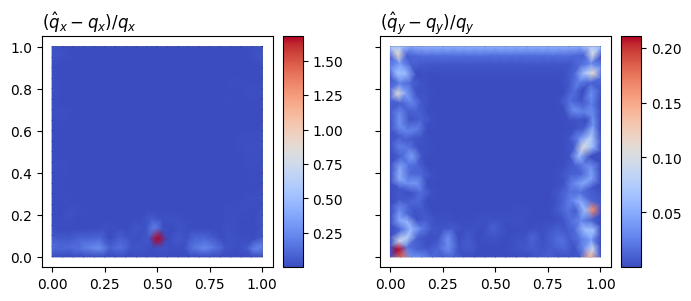

In [9]:
[kx] = np.where(abs(q_x_true) > 1.e-8)
[ky] = np.where(abs(q_y_true) > 1.e-8)
rel_q_x = np.zeros_like(abs_q_x)
rel_q_y = np.zeros_like(abs_q_y)
rel_q_x[kx] = abs_q_x[kx]/abs(q_x_true[kx])
mx = np.setdiff1d(np.arange(mesh.number_nodes), kx)
rel_q_x[mx] = abs_q_x[mx]
rel_q_y[ky] = abs_q_y[ky]/abs(q_y_true[ky])
my = np.setdiff1d(np.arange(mesh.number_nodes), ky)
rel_q_y[my] = abs_q_y[my]

fig, axs = plt.subplots(1, 2, sharey='all', figsize=(8, 3))
mesh.plot(rel_q_x, ax=axs[0], cmap='coolwarm')
mesh.plot(rel_q_y, ax=axs[1], cmap='coolwarm')

axs[0].set_title('$(\hat{q}_x - q_x)/q_x$ ', loc='left')
axs[1].set_title('$(\hat{q}_y -q_y)/q_y$', loc='left')

for ax in axs:
    ax.set_aspect(1)


## Exercise 1.2 Mesh of a sheet-pile wall

Here, you will write a script to mesh the geometry of a sheet-pile wall. Below you will find an example how to build a unit square by providing coordinates of each node. You can use the same logics to build the geometry of a dam.

Text(0, 0.5, 'y (m)')

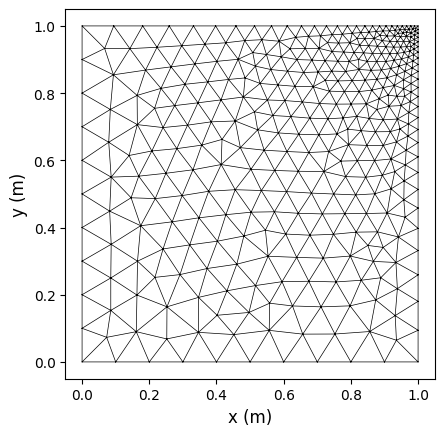

In [10]:
vertices = np.array([[0, 0],
                     [1, 0],
                     [1, 1],
                     [0, 1]])

# we can have a per point cell resolution, telling pygmsh where we want finer elements
# there are multiple ways to do this, but a simple one is to make a list as long as our points
resolutions = np.array([0.1, 0.1, 0.01, 0.1])

with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for i in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[i + 1], resolutions[i + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)

    # final command to do the computations
    out = geom.generate_mesh()

# we pass it to our wrapper object 'Mesh' with which we'll be interacting through our computations
mesh = Mesh(out)

# we can use the mesh.plot() function to easily show it

fig, ax = mesh.plot()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

Please build the mesh of the sheet pile of figure 1. Take the dimensions as you want.

(9.999998, 10.000002)

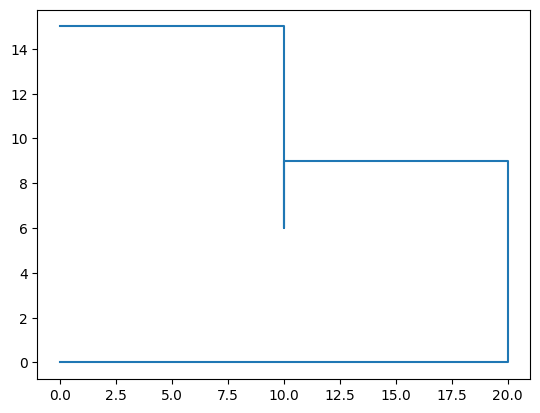

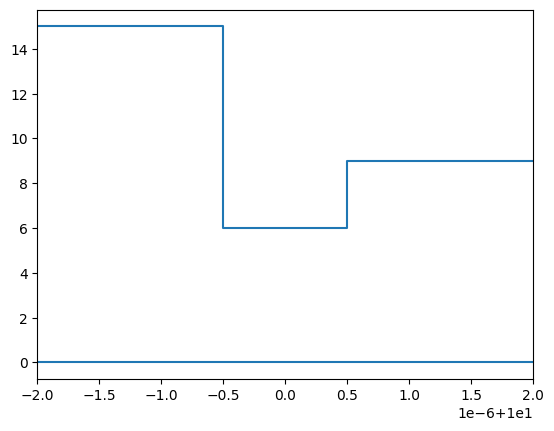

In [11]:
# We define the different dimensions of the problem
D = 15
H = 6
s = 10
b = 10
t = 3

# As to get a mesh that is conform, we need to introduce a very small width of our wall
twall = 1e-6

# we can now define the vertices using the dimensions. We start from the left bottom and place it at [0, 0] and then go clockwise
vertices = np.array([[0, 0],
                     [s + b + twall, 0],
                     [s + b + twall, D - H],
                     [s + twall/2, D - H],
                     [s + twall/2, D - H - t],
                     [s - twall/2, D - H - t],
                     [s - twall/2, D],
                     [0, D]])

# we can have a per point cell resolution, telling pygmsh where we want finer elements
# there are multiple ways to do this, but a simple one is to make a list as long as our points
resolutions = np.array([1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 0.1, 1.0])

# We simply inspect how the boundaries look like
plt.figure()
plt.plot(vertices[:, 0], vertices[:, 1])
plt.gca().set_aspect(1)
# Note: That the bottom is not closed when plotting in this manner. This is because for the meshing we will not repeat a vertex.

# To see the separation caused by the wall we need to zoom in closer
plt.figure()
plt.plot(vertices[:, 0], vertices[:, 1])
plt.xlim(s - 2*twall, s + 2*twall)

It is now possible to use the vertices and resolution we have defined above to build the mesh. The procedure is exactly as in the example above.

Text(0, 0.5, 'y (m)')

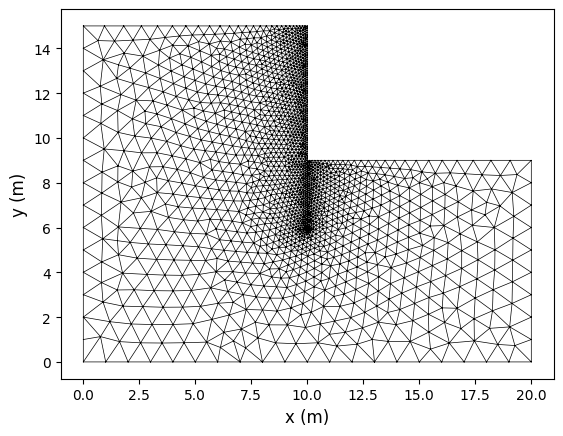

In [12]:
with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for i in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[i + 1], resolutions[i + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)

    # final command to do the computations
    out = geom.generate_mesh()

# we pass it to our wrapper object 'Mesh' with which we'll be interacting through our computations
mesh = Mesh(out)

# we can use the mesh.plot() function to easily show it

fig, ax = mesh.plot()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')